# Classification using Transformer

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
stop_words = stopwords.words('korean')
from konlpy.tag import Okt
import googletrans
import re
from typing import List

from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import urllib
import time
from tqdm import tqdm_notebook

## Load Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.shape)
train.head()

(25000, 3)


,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


## Data Augmentation

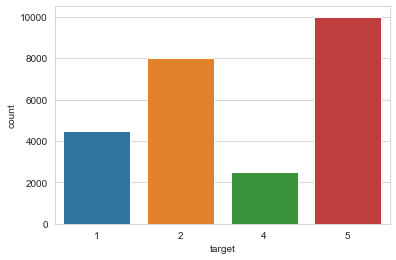

In [3]:
sns.set_style('whitegrid')
sns.countplot(data=train, x='target')
plt.show()

라벨 간 불균형을 조정하기 위해 번역을 활용한 데이터 증강기법 적용

1. 한글 > 영어 > 한글 역번역
- 번역기의 버전 차이인지 실제 웹 상에서의 번역 결과와 googletrans를 통한 번역 결과가 다름
- '별로'를 'good'으로 번역하는 등의 이슈가 발생

In [ ]:
translator = googletrans.Translator()

In [ ]:
for i in [11,121,1331]:
    original = train['reviews'].iloc[i]
    translated = translator.translate(original, dest='en', src='ko').text
    result = translator.translate(translated, dest='ko', src='en').text

    print(original)
    print(translated)
    print(result)
    print('-'*50)

화면하고 전혀틀림
The screen is completely different
화면은 완전히 다릅니다
--------------------------------------------------
배송도 빠르고 눈썹은 괜찮은데 글로가 정말 별로네요ㅜ
The delivery is fast and the eyebrows are fine, but the writing is really good.
배달은 빠르고 눈썹은 괜찮지 만 글은 정말 좋습니다.
--------------------------------------------------
재구매 빠른배송 감사합니다 노란색이 더좋았어요
Thank you for your repurchase fast delivery. The yellow color was better.
재구매 빠른 배송에 감사드립니다.노란색이 더 좋았습니다.
--------------------------------------------------


2. NLPAUG 동의어 변환
- WordNet에서 한글 소스가 존재하지 않음

In [ ]:
import nlpaug.augmenter.word as naw

aug = naw.SynonymAug()
text = 'red apple'
aug.augment(text)

['red orchard apple tree']

3. 역번역 중간에 NLPAUG 적용
- 번역된 문장이 올바를 경우에 원본 문장의 감정을 변질시키지 않고 다른 표현으로 변환할 수 있음을 확인

In [ ]:
for i in [11,121,1331]:
    original = train['reviews'].iloc[i]
    translated = translator.translate(original, dest='en', src='ko').text
    augmented = aug.augment(translated)[0]
    result = translator.translate(augmented, dest='ko', src='en').text

    print(original)
    print(translated)
    print(augmented)
    print(result)
    print('-'*50)

화면하고 전혀틀림
The screen is completely different
The blind be completely different
블라인드는 완전히 다릅니다
--------------------------------------------------
배송도 빠르고 눈썹은 괜찮은데 글로가 정말 별로네요ㅜ
The delivery is fast and the eyebrows are fine, but the writing is really good.
The livery constitute tight and the brow are fine, just the writing is really good.
정복은 단단하고 눈썹은 괜찮습니다. 글쓰기 만 정말 좋습니다.
--------------------------------------------------
재구매 빠른배송 감사합니다 노란색이 더좋았어요
Thank you for your repurchase fast delivery. The yellow color was better.
Thank you for your repurchase fast delivery. The yellow colouring material be well.
재구매 빠른 배송에 감사드립니다.노란색 채색 재료가 잘됩니다.
--------------------------------------------------


4. 토큰 단위로 역번역
- 문장 번역보다는 그럴듯한 결과가 나왔지만, 역번역이 여전히 어설프고 번역 속도가 너무 느림

In [ ]:
def ko_tokenize(sentence):
    okt = Okt()
    sentence = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','',sentence)
    tokenized = okt.morphs(sentence)
    return [word for word in tokenized if word not in stop_words]

In [ ]:
for i in [11,121,1331]:
    original = ko_tokenize(train['reviews'].iloc[i])
    translated = [translator.translate(token, dest='en', src='ko').text for token in original]
    result = [translator.translate(token, dest='ko', src='en').text for token in translated]
    result = ko_tokenize(' '.join(result))

    print(original)
    print(translated)
    print(result)
    print('-'*50)

['화면', '하고', '전혀', '틀림']
['screen', 'do', 'Not at all', 'error']
['화면', '전혀', '오류']
--------------------------------------------------
['배송', '빠르고', '눈썹', '괜찮은데', '글로', '정말', '별로', '요', 'ㅜ']
['shipping', 'Fast', 'Eyebrow', "It's okay", 'Writings', 'really', 'not really', 'yo. this', 'sob']
['배송', '빠른', '눈썹', '괜찮아요', '진짜', '에야', '디', '흐', '느낌']
--------------------------------------------------
['재구매', '빠른', '배송', '감사합니다', '노란색', '더', '좋았어요']
['Repurchase', 'fast', 'shipping', 'thank you', 'yellow', 'more', 'It was good']
['환매', '빠른', '배송', '감사합니다', '노란색', '더', '좋았습니다']
--------------------------------------------------


5. Word2Vec를 활용한 유사어 변환
- 외부 데이터를 활용하지 못하는 환경에서는 원본 데이터의 단어를 조합하는 수준에 불과하기 때문에 유의미한 결과를 내지 못할 것이라 판단
- 또한 서로 다른 감정의 단어를 묶어서 벡터를 생성할 경우 1점 리뷰에 '감사합니다'라는 단어가 들어가는 등의 예측을 방해하는 노이즈가 발생하는 이슈를 확인

In [ ]:
from gensim.models import Word2Vec

num_features = 300
train_data = [ko_tokenize(data) for data in train['reviews']]
model = Word2Vec(sentences=train_data, vector_size=num_features, window=5, min_count=1, workers=4, sg=0)

In [ ]:
for i in [11,121,1331]:
    original = ko_tokenize(train['reviews'].iloc[i])
    result = list()
    for token in original:
        synonym = model.wv.most_similar(token)[0]
        result.append(synonym[0] if synonym[1] > 0.95 else token)
    result = list(set(result))

    print(original)
    print(result)
    print('-'*50)

['화면', '하고', '전혀', '틀림']
['베란다', '계란', '시중', '해서']
--------------------------------------------------
['배송', '빠르고', '눈썹', '괜찮은데', '글로', '정말', '별로', '요', 'ㅜ']
['충전', '빨랐어요', '양도', '기네', '글로', '였어요', '감사합니다', '특히', '손']
--------------------------------------------------
['재구매', '빠른', '배송', '감사합니다', '노란색', '더', '좋았어요']
['빨라요', '사이트', '라서', '거리', '항상', '친절하고', '감사합니다']
--------------------------------------------------


6. 파파고 크롤링을 활용한 한영 번역 후 구글 번역을 통한 역번역
- 파파고 API를 활용 시 더욱 빨리 번역을 진행할 수 있지만, 글자 수 단위로 과금이 발생하기에 크롤링으로 번역되지 않는 문장에 한해 시행
- 평점 5점에 대한 리뷰의 경우 증강을 진행하지 않을 것이기 때문에 번역할 필요가 없지만, 시간이 남아 같이 진행

In [ ]:
print('전체 글자 수:', sum([len(review) for review in train['reviews']]))

전체 글자 수: 999702


In [ ]:
service = Service(executable_path=ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

src, dest = 'ko', 'en'
translate_url = f'https://papago.naver.com/?sk={src}&tk={dest}'

driver.get(translate_url)
time.sleep(3)

for i in [11,121,1331]:
    original = train['reviews'].iloc[i]

    driver.find_element(By.ID, 'txtSource').clear()
    driver.find_element(By.ID, 'txtSource').send_keys(original)

    time.sleep(3)
    translated = driver.find_element(By.ID, 'txtTarget').text
    result = translator.translate(translated, dest=src, src=dest).text

    print(original)
    print(translated)
    print(result)
    print('-'*50)

driver.close()


화면하고 전혀틀림
Completely different from the screen
화면과 완전히 다릅니다
--------------------------------------------------
배송도 빠르고 눈썹은 괜찮은데 글로가 정말 별로네요ㅜ
The delivery is fast and the eyebrows are okay, but the writing is really bad
배달은 빠르고 눈썹은 괜찮지 만 글은 정말 나쁘다
--------------------------------------------------
재구매 빠른배송 감사합니다 노란색이 더좋았어요
Thank you for repurchase and fast shipping I liked yellow more
재구매하고 빠른 배송 감사합니다. 나는 노란색 더 좋아했습니다.
--------------------------------------------------


### Data Augmentation Process
1. 파파고 크롤링을 통해 한글 리뷰를 영어로 변환한 데이터프레임 생성
2. NLPAUG 라이브러리의 동의어 변형 기법을 활용해 랜덤한 문장을 필요한 수만큼 증강
3. 이때, 한글로 완벽하게 번역되지 않는 문장을 제거하면서 목표한만큼의 문장을 생성
4. 증강된 영문을 구글 번역을 통해 역번역해 한글 리뷰 데이터 추가

In [ ]:
total_delay = sum([np.sqrt(np.log(len(review)))+1 for review in train['reviews']])
expected_time = int((3 + total_delay) // 60)
print(f'예상 시간: {expected_time}분')

예상 시간: 1184분


In [ ]:
service = Service(executable_path=ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

src, dest = 'ko', 'en'
translate_url = f'https://papago.naver.com/?sk={src}&tk={dest}'
train['translated'] = None
translated, error = list(), list()

driver.get(translate_url)
time.sleep(3)

for i, review in enumerate(tqdm_notebook(train['reviews'][11355:]),11355):
    try:
        driver.find_element(By.ID, 'txtSource').clear()
        driver.find_element(By.ID, 'txtSource').send_keys(review)
        time.sleep(np.sqrt(np.log(len(review)))+1)
        train['translated'][i] = driver.find_element(By.ID, 'txtTarget').text
    except:
        pass

driver.close()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          25000 non-null  int64 
 1   reviews     25000 non-null  object
 2   target      25000 non-null  int64 
 3   translated  24920 non-null  object
dtypes: int64(2), object(2)
memory usage: 781.4+ KB


크롤링 중 딜레이가 충분하지 않아 이전에 번역된 문장이 저장되거나, 이모티콘 등으로 인해 번역이 진행되지 않은 경우를 확인   
해당하는 행들을 추출하여 파파고 API를 통해 한영 번역 시도

In [ ]:
headers = {
    'X-NCP-APIGW-API-KEY-ID': 'YOUR_CLIENT_ID',
    'X-NCP-APIGW-API-KEY': 'YOUR_CLIENT_SECRET'
}
url = 'https://naveropenapi.apigw.ntruss.com/nmt/v1/translation'
errors = dict()

untranslated = train[(train['translated'].duplicated()) | (train['translated'].isna())]
indices = untranslated.index
reviews = untranslated['reviews']

for i, review in zip(indices, reviews):
    data = 'source=ko&target=en&text=' + urllib.parse.quote(review)
    request = urllib.request.Request(url, headers=headers)
    response = urllib.request.urlopen(request, data=data.encode('utf-8'))
    rescode = response.getcode()
    if rescode == 200:
        response_body = response.read().decode('utf-8')
        translated = re.search('"translatedText":"(.+?)"', response_body).group(1)
        train['translated'][i] = translated.encode('utf-8', 'ignore').decode('utf-8').strip()
    else:
        errors[i] = rescode

번역 결과에 포함된 이모티콘 유니코드를 출력 가능한 형태로 변환하기 어려워 문자열 인코딩을 통해 제거

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          25000 non-null  int64 
 1   reviews     25000 non-null  object
 2   target      25000 non-null  int64 
 3   translated  25000 non-null  object
dtypes: int64(2), object(2)
memory usage: 781.4+ KB


In [ ]:
train.to_csv('translated.csv',index=False)

## Preprocess Data

In [4]:
train['reviews'] = train['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
test['reviews'] = test['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')

train['reviews'] = train['reviews'].str.replace('^ +','')
test['reviews'] = test['reviews'].str.replace('^ +','')

In [5]:
okt = Okt()
train_data = [ko_tokenize(review) for review in train['reviews'].tolist()]
train_label = train['target'].tolist()
test_data = [ko_tokenize(review) for review in test['reviews'].tolist()]

num_aug = train['target'].value_counts().max()
for rate in train['target'].unique():
    reviews = train[train['target']==rate]['reviews'].tolist()
    if len(reviews) == num_aug:
        continue

    augmented = word2vec_aug(reviews, num_aug)
    train_data += augmented
    train_label += [rate for _ in range(len(augmented))]

In [ ]:
pd.DataFrame({'reviews':train_data,'target':train_label}).to_csv('data/tokenized1.csv',index=False)

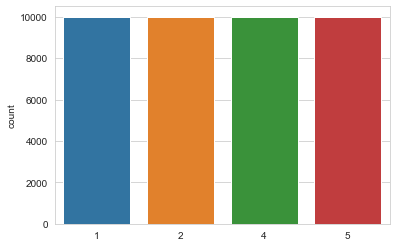

In [7]:
sns.set_style('whitegrid')
sns.countplot(data={'target':train_label}, x='target')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = \
    train_test_split(train_data, train_label, test_size=0.3,
                        stratify=train_label, shuffle=True, random_state=0)

print(len(train_X), len(train_y), len(val_X), len(val_y))

17500 17500 7500 7500


## Transformer

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [2]:
vocab_size = 20000  # 빈도수 상위 2만개의 단어만 사용
max_len = 200  # 문장의 최대 길이

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))

17464789/17464789 [==============================] - 2s 0us/step
훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000


In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [ ]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_test, y_test))

print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

In [ ]:
print(train_X['input_ids'][0])

[2, 12978, 3409, 5926, 11988, 16, 16305, 5868, 8297, 13365, 5842, 6136, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(train_X['token_type_ids'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(train_X['attention_mask'][0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, initializers, losses, optimizers, metrics, callbacks 

SEQ_LEN = 512 # 최대 token 개수 이상의 값으로 임의로 설정

koelectra = ElectraModel.from_pretrained('monologg/koelectra-base-discriminator')

input_token_ids   = layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_token_ids')   # tokens_tensor
input_masks       = layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')       # masks_tensor
input_segments    = layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segments')    # segments_tensor  

koelectra_outputs = koelectra([input_token_ids, input_masks, input_segments]) 
# koelectra_outputs -> 0: 'last_hidden_state' & 1: 'pooler_output' (== applied GlobalAveragePooling1D on 'last_hidden_state')

koelectra_outputs = koelectra_outputs[1]
koelectra_outputs = layers.Dropout(0.2)(koelectra_outputs)
final_output = layers.Dense(units=4, activation='softmax', kernel_initializer=initializers.TruncatedNormal(stddev=0.02), name="classifier")(koelectra_outputs)

model = tf.keras.Model(inputs=[input_token_ids, input_masks, input_segments], 
                       outputs=final_output)

In [ ]:
import os

checkpoint_path = 'saved_models/'

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)


# For custom models, we have to use "save_weights_only = True" (or we should implement a "get_config" method @ https://j.mp/3ltUibd) 
callback_checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path + 'koelectra_weight.h5', # 이번 실습에서 변경되었습니다
                                                monitor='val_sparse_categorical_accuracy',
                                                save_best_only=True, 
                                                save_weights_only = True, 
                                                verbose=1) 
                                                
# Early-stopping for preventing the overfitting
callback_earlystop = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                             min_delta=0.0001, # the threshold that triggers the termination (acc should at least improve 0.0001)
                                             patience=5) #  Number of epochs with no improvement after which training will be stopped

In [ ]:
# 25분 가량 소요됩니다 (epochs를 4~5 정도로 주더라도 비슷한 수준으로 학습이 가능합니다)

history = model.fit(train_X, train_y, validation_split=0.2,
                    epochs=10, batch_size=100,
                    verbose=1,
                    callbacks=[callback_checkpoint, callback_earlystop])